In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model & reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Get a list of column names and types
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])
print('-----------')
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_tuple = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = most_recent_tuple[0]

# Calculating the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

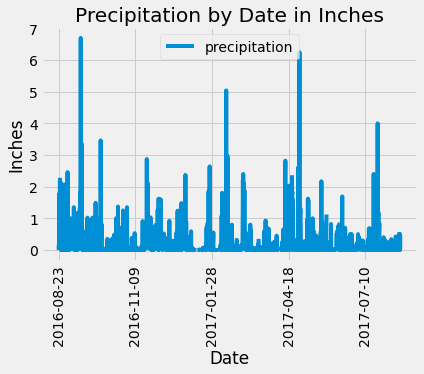

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Using this date, retrieve the last 12 months of precipitation data by querying the 
# 12 preceding months of data. Note you do not pass in the date as a variable to your query.


twelve_months = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
twelve_months_df = pd.DataFrame(twelve_months, columns=['date', 'prcp'])
twelve_months_df = twelve_months_df.rename(columns={'prcp': 'precipitation'})

# Use Pandas Plotting with Matplotlib to plot the data
# Plot the dataframe as a horizontal bar chart using pandas plotting
twelve_months_df.plot(x='date', y="precipitation", title="Precipitation by Date in Inches", rot=90)
plt.ylabel("Inches")
plt.xlabel("Date")
plt.show()


In [23]:
session = Session(engine)

results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23').order_by(Measurement.date).all()

# closing the session
session.close()

# Converting list of tuples into a dictionary
prcp_dict = {}

for date, prcp in results:
    if date in prcp_dict:
        prcp_dict[date] = prcp_dict[date] + prcp
    else:
        prcp_dict[date] = prcp

TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
twelve_months_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
num_stations = session.query(Station.station).count()
print(num_stations)

9


In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station, func.count(Measurement.prcp)]
station_counts = session.query(*sel).group_by(Measurement.station).order_by(sel[1]).all()

most_active = station_counts[-1][0]

for station in station_counts:
    print(f"{station[0]}: {station[1]}")

USC00518838: 342
USC00517948: 683
USC00511918: 1932
USC00514830: 1937
USC00516128: 2484
USC00519523: 2572
USC00519397: 2685
USC00513117: 2696
USC00519281: 2772


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
most_active_stats = session.query(*sel).filter(Measurement.station == most_active).all()
most_active_stats

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

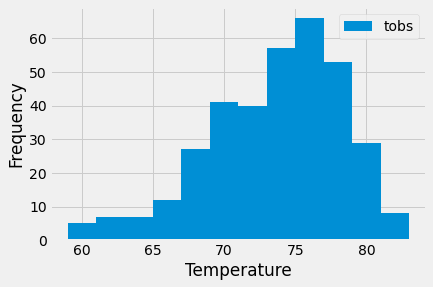

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_year = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= '2016-08-23').filter(Measurement.station == most_active).order_by(Measurement.date).all()

active_year_df = pd.DataFrame(active_year, columns=['date', 'tobs'])

active_year_df.plot.hist(bins=12)
plt.xlabel("Temperature")

plt.show()

# Close session

In [18]:
# Close Session
session.close()